In [22]:

from scipy.optimize import minimize
from qiskit import *
from qiskit.tools.monitor import job_monitor
import numpy as np
from scipy.optimize import minimize
from pylab import *

In [2]:
bit = ['0','1']
dic = []
for i in bit:
    for j in bit:
        dic.append(i+j)
dic

['00', '01', '10', '11']

In [28]:
# 1. Quantum_module_Z caculate expectation energy for terms of sigma z 
def module_Z(teta):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    q = circuit.qregs[0]
    circuit.u3(teta[0], teta[1], 0, q[1])
    circuit.cu3(teta[2], teta[3], 0, q[1],q[0])
    circuit.x(q[1])
    circuit.cu3(teta[4], teta[5], 0, q[1],q[0])
    #circuit.cx(q[1],q[0])
#     circuit.ry(teta[6], q[0])
#     circuit.ry(teta[7], q[1])
   
    circuit.measure(range(2),range(2))
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    
    shots = 18192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    
# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count     
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    
    e = 0
    for i in counts.keys():
        if i[0] == i[1]:
            e += counts[i]
        else:
            e -= counts[i]

    # expectation value of energy estimation from counts
    E_J = -2*e/shots
    return E_J
# 2. Quantum_module_X caculate expectation energy for terms of sigma x
def module_X(teta):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    q = circuit.qregs[0]
    circuit.u3(teta[0], teta[1], 0, q[1])
    circuit.cu3(teta[2], teta[3], 0, q[1],q[0])
    circuit.x(q[1])
    circuit.cu3(teta[4], teta[5], 0, q[1],q[0])
    
    #circuit.cx(q[1],q[0])
#     circuit.ry(teta[6], q[0])
#     circuit.ry(teta[7], q[1])
   
   # measurement 
# Add Hadamard gate before put measurement gate to change measurement axis from z to x 
    circuit.h(q[0])
    circuit.h(q[1])
   
    circuit.measure(range(2), range(2))
    
# Executing the circuit by qasm_simulation to caculate energy from result.get(counts)    

    shots = 18192
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()

# get full possible keys for counts otherwise we might encounter KeyError where we count nothing for a key
# Remember dic is the list that contain all 2^4=16 possible keys, appending key for count where key in dic but not in count 
    
    for i in dic:
        if i not in counts:
            counts[i] = 0
# function to calculate probability
    def prob(j):
        e = 0
        for i in counts.keys():
            if i[j] == '0':
                e += counts[i]
            else:
                e -= counts[i]
        return e/shots 
# expectation value estimation from counts

    E_Z = -(prob(0)+prob(1))
    return E_Z

# expectation value total 
def vqe(teta):
    # Summing the measurement results
    classical_adder = module_Z(teta) + h * module_X(teta)
    return classical_adder

In [24]:
teta = [1,2,3,4,5,6]
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)

# quantum state preparation
q = circuit.qregs[0]
# Uncomment these following 6 lines by pressing " CTRL / " to prepare ENTANGLE states of 4 qubits
circuit.u3(teta[0], teta[1], 0, q[1])
circuit.cu3(teta[2], teta[3], 0, q[1],q[0])
circuit.x(q[1])
circuit.cu3(teta[4], teta[5], 0, q[1],q[0])
#circuit.cx(q[1],q[0])
# circuit.ry(teta[6], q[0])
# circuit.ry(teta[7], q[1])
circuit.draw()

┌───────────┐     ┌───────────┐
q565_0: ─────────────┤ U3(3,4,0) ├─────┤ U3(5,6,0) ├
        ┌───────────┐└─────┬─────┘┌───┐└─────┬─────┘
q565_1: ┤ U3(1,2,0) ├──────■──────┤ X ├──────■──────
        └───────────┘             └───┘             
c106: 2/════════════════════════════════════════════

In [26]:
vqe(teta=[1.5708,0,1.10715,0,2.03444,0],h=2)/2

-2.220206684256816

In [15]:
-np.sqrt(1+2*2)

-2.23606797749979

In [36]:
# from numpy import random
# l = np.pi*random.rand()
teta0=[1.5708,0,1.10715,0,2.03444,0]
tol = 1e-3 # tolerance for optimization precision.
# Get expectation energy by optimization with corresponding h = 0.1, 0.2,..., 2.9, 3. 
y_vqe = []
for k in range(0,20):
    h = k/10
    vqe_result = minimize(vqe, teta0 , method="COBYLA", tol=tol)
    y_vqe.append(vqe_result.fun)

In [16]:
tol = 1e-3 # tolerance for optimization precision.
y_vqe = []
h = 2
vqe_result = minimize(vqe, [1.5708,0,1.10715,0,2.03444,0] , method="COBYLA", tol=tol)
y_vqe.append(vqe_result.fun)

-1.983560844010028

Text(0.5, 1.0, 'VQE vs Exact Diagonal')

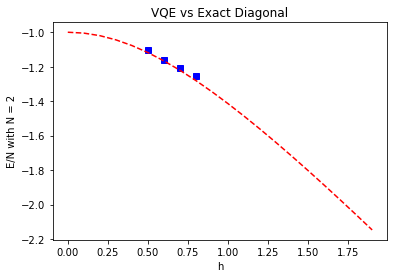

In [35]:
y_mean = np.array(y_vqe)/2
x2 = []
for k in range(0,20):
    x2.append(k/10)
# 
x = []
for k in range(5,9):
    x.append(k/10)

z_mean = -np.sqrt(np.array(x2)**2+1)
plot(x,y_mean,'bs', label='VQE')
plot(x2,z_mean, 'r--',label='Exact')

plt.xlabel('h')
plt.ylabel('E/N with N = 2')
plt.title('VQE vs Exact Diagonal')

Text(0.5, 1.0, 'VQE vs Exact Diagonal')

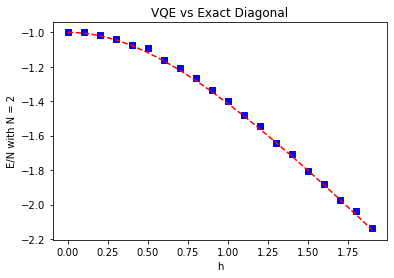

In [38]:
y_mean = np.array(y_vqe)/2

x = []
for k in range(0,20):
    x.append(k/10)

z_mean = -np.sqrt(np.array(x)**2+1)
plot(x,y_mean,'bs', label='VQE')
plot(x,z_mean, 'r--',label='Exact')

plt.xlabel('h')
plt.ylabel('E/N with N = 2')
plt.title('VQE vs Exact Diagonal')

In [ ]:
# y_mean = np.array(y_vqe)/2

# # 
# x = []
# for k in range(1,21):
#     x.append(k/10)
# z_mean = -np.sqrt(np.array(x)**2+1)
# plot(x,y_mean,'bs', label='VQE')
# plot(x,z_mean, 'r--',label='Exact')

# plt.xlabel('h')
# plt.ylabel('E/N with N = 2')
# plt.title('VQE vs Exact Diagonal')